<font color='blue'>
## Generate Vp and AI logs from Sonic and Density 
## - an example code without ML component
## - in this example we used the package lasio to read las files. It requires a pip install if the package is not there

## install lasio package to read las files; msgpack is required by lasio
### either can install here or in the terminal

In [2]:
!pip install msgpack
!pip install lasio

    100% |████████████████████████████████| 204kB 18.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for ordereddict ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/78/d3/a8/9f52c7a389a0ffba6f575a3886b5f7a55461fb6ec34aa5fd38
Successfully built ordereddict
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 317kB 20.0MB/s ta 0:00:01
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## import packages

In [3]:
%%time
import matplotlib.pyplot as plt
import lasio

import awscli
import os
import boto3
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name

bucket='sdu-machine-learning'
prefix = '/pphys/'

#bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)
bucket_path = 's3://sdu-machine-learning'

CPU times: user 704 ms, sys: 80 ms, total: 784 ms
Wall time: 2.36 s


<font color='red'> 
## missing elements: 
## read data from SDU
## How do we access data directly from S3? Some functions like lasio and geoio does not support this.  


## As the lasio package can not read data directly from S3, we first download it to EC2 

In [4]:
lasfile = 'GC110-1-SHELL.las'
lasfile_s3 = bucket_path+prefix+lasfile
!aws s3 cp $lasfile_s3 input/

download: s3://sdu-machine-learning/pphys/GC110-1-SHELL.las to input/GC110-1-SHELL.las


## read input las file from EC2

In [1]:
# import urllib
# #opener = urllib.request.urlopen()
# #myurl = "https://s3.amazonaws.com/skyl/fake.xyz"
# myurl = "https://s3.amazonaws.com/sdu-machine-learning/pphys/GC110-1-SHELL.las"
# myfile = urllib.request.urlopen(myurl)#opener.open(myurl)

In [106]:
# read las file
lasfile_ec2 = 'input/'+lasfile
las = lasio.read(lasfile_ec2)
#las = lasio.read(lasfile_s3)

In [51]:
# for curve in las.curves:
#     print(curve.mnemonic)
#     print(curve.unit)
#     #print("\n")

## define new logs Vp and AI

In [93]:
las["Vp"]=1000000/(las["DTC"]*3.28084)
las["AI"]=las["Vp"]*las["DEN"]

Text(0.5,1,'Acoustic Impedence (m.g/s.cm^3)')

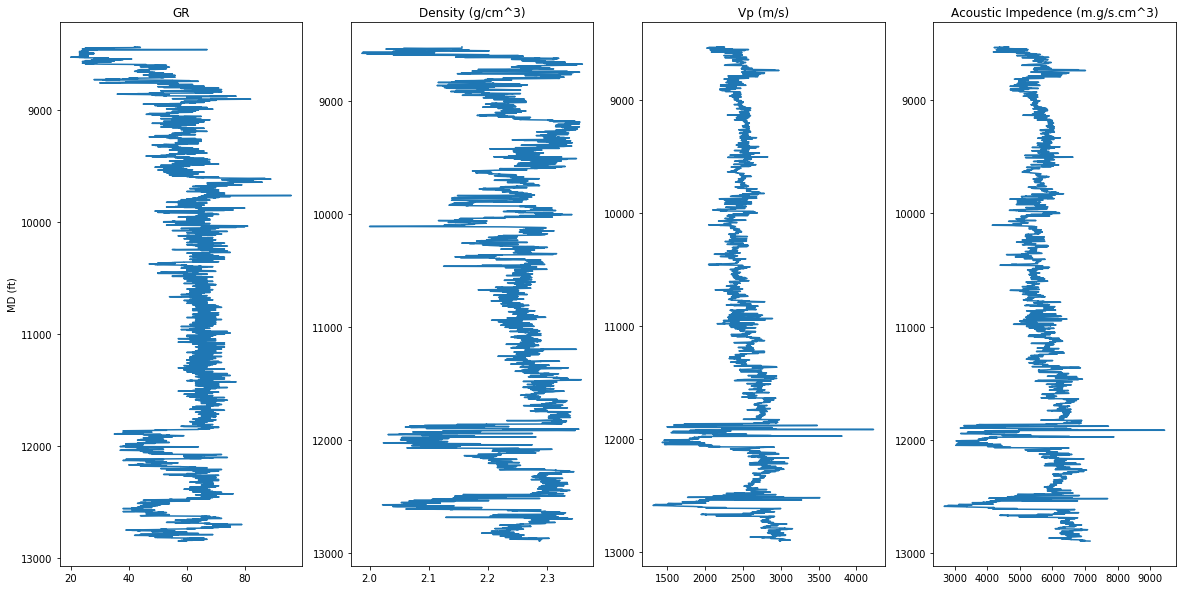

In [94]:
# display the logs
fig = plt.figure(figsize=(20,10))
plt.subplot(141)
plt.plot(las["GR"],las["DEPT"])
plt.ylabel('MD (ft)')
plt.title('GR')
plt.gca().invert_yaxis()
plt.subplot(142)
plt.plot(las["DEN"],las["DEPT"])
plt.title('Density (g/cm^3)')
plt.gca().invert_yaxis()
plt.subplot(143)
plt.plot(las["Vp"],las["DEPT"])
plt.gca().invert_yaxis()
plt.title('Vp (m/s)')
plt.subplot(144)
plt.plot(las["AI"],las["DEPT"])
plt.gca().invert_yaxis()
plt.title('Acoustic Impedence (m.g/s.cm^3)')

## save new data to EC2 output folder

In [95]:
outdir = 'output/'
fout = outdir+'GC110-1-SHELL_vpAI.las'
las.write(fout, version=2.0)


## copy the new data from EC2 drive to S3 bucket

In [97]:
s3_path = bucket_path+prefix
!aws s3 cp $fout $s3_path
#!aws s3 cp output/GC110-1-SHELL_vpAI.las s3://sdu-machine-learning/pphys/    

upload: output/GC110-1-SHELL_vpAI.las to s3://sdu-machine-learning/pphys/GC110-1-SHELL_vpAI.las


<font color='red'> 
## missing element:
## How do we publish data back to SDU?